In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
bc = pd.read_csv('Data/file1.csv')
bc

,Date,Open,High,Low,Close,Adj Close,Volume,Return,Day of Week
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,2.105680e+07,NaN,Wed
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,3.448320e+07,-0.071926,Thu
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,3.791970e+07,-0.069843,Fri
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,3.686360e+07,0.035735,Sat
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,2.658010e+07,-0.024659,Sun
...,...,...,...,...,...,...,...,...,...
2580,2021-10-14,57372.832031,58478.734375,56957.074219,57321.523438,57321.523438,3.661579e+10,-0.001386,Thu
2581,2021-10-15,57345.902344,62757.128906,56868.144531,61593.949219,61593.949219,5.178008e+10,0.074534,Fri
2582,2021-10-16,61609.527344,62274.476563,60206.121094,60892.179688,60892.179688,3.425096e+10,-0.011393,Sat
2583,2021-10-17,60887.652344,61645.523438,59164.468750,61553.617188,61553.617188,2.903237e+10,0.010862,Sun


# Modeling

In [3]:
import fbprophet
print('Prophet %s' % fbprophet.__version__)

from pandas import to_datetime
from fbprophet import Prophet
import datetime
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

Prophet 0.7.1


In [4]:
bc_date_adjclose = bc[['Date', 'Adj Close']]
#rename to the required format for prophet
bc_date_adjclose.columns = ['ds', 'y']
# define the model
model = Prophet()
# fit the model on the entire dataset
model.fit(bc_date_adjclose)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [5]:
#Make a dataframe for future predictions and specify the capacity in the future. 
#Predict next 365 after the final date of October 18, 2021
future = model.make_future_dataframe(periods=365,freq='D')
forecast = model.predict(future)

In [6]:
#View the predicted 100 days
forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]

,ds,yhat_lower,yhat_upper,yhat
0,2014-09-17,-7544.575716,3537.004446,-2103.926998
1,2014-09-18,-7704.652606,3117.845864,-2172.621575
2,2014-09-19,-7151.398033,3757.701738,-2129.365334
3,2014-09-20,-7685.975410,2958.658956,-2185.379230
4,2014-09-21,-7945.489087,3466.087831,-2236.996334
...,...,...,...,...
2945,2022-10-14,79876.274130,96017.180785,88404.078093
2946,2022-10-15,80573.271459,97021.298194,88531.620518
2947,2022-10-16,80749.382555,97220.486326,88647.697479
2948,2022-10-17,80593.676892,96901.106368,88807.653372


In [7]:
#Rename the columns for better interpretation
col = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']
forecast[col].rename(columns={'ds':'Date', 'yhat': 'Prediction', 'yhat_lower':'Lower Prediction',
                     'yhat_upper': 'Upper Prediction'})

,Date,Lower Prediction,Upper Prediction,Prediction
0,2014-09-17,-7544.575716,3537.004446,-2103.926998
1,2014-09-18,-7704.652606,3117.845864,-2172.621575
2,2014-09-19,-7151.398033,3757.701738,-2129.365334
3,2014-09-20,-7685.975410,2958.658956,-2185.379230
4,2014-09-21,-7945.489087,3466.087831,-2236.996334
...,...,...,...,...
2945,2022-10-14,79876.274130,96017.180785,88404.078093
2946,2022-10-15,80573.271459,97021.298194,88531.620518
2947,2022-10-16,80749.382555,97220.486326,88647.697479
2948,2022-10-17,80593.676892,96901.106368,88807.653372


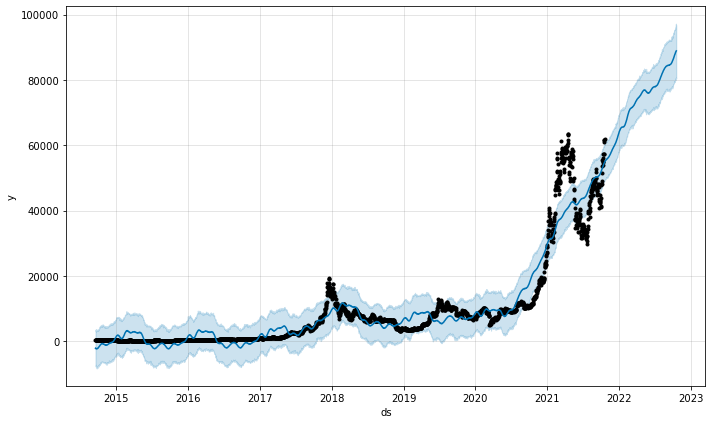

In [8]:
#Plotting the predicted values 
plot1 = model.plot(forecast)

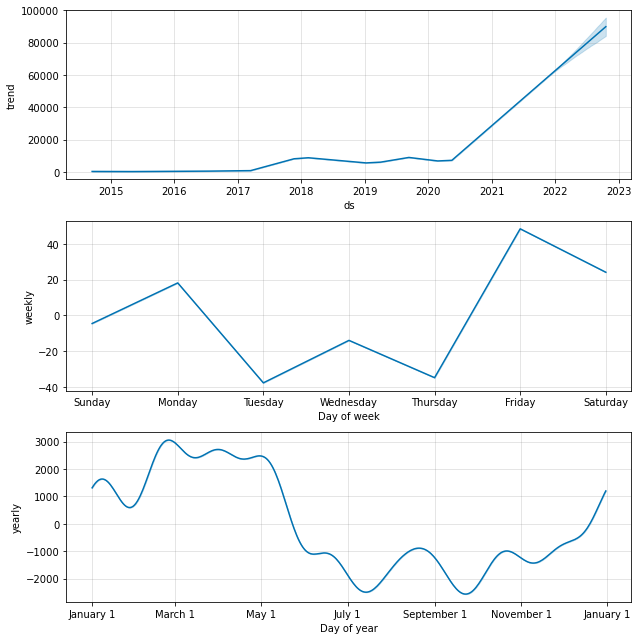

In [9]:
#Plotting the Forecasted components(Trend and Seasonality)
plt2 = model.plot_components(forecast)

# Hyperparameter Tuning

If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible:

In [10]:
import itertools

param_grid = {'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.25, 0.5]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(bc_date_adjclose)  # Fit model with given params
    df_cv = cross_validation(m, horizon='100 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 43 forecasts with cutoffs between 2015-10-10 00:00:00 and 2021-07-10 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001705A338B50>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 43 forecasts with cutoffs between 2015-10-10 00:00:00 and 2021-07-10 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001705C4434F0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 43 forecasts with cutoffs between 2015-10-10 00:00:00 and 2021-07-10 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001705656AD90>
INFO:fbprophet:Disabling daily season

   changepoint_prior_scale          rmse
0                    0.001  11328.910912
1                    0.010   9008.865811
2                    0.100   8485.303696
3                    0.250   8528.399930
4                    0.500   8700.425324


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


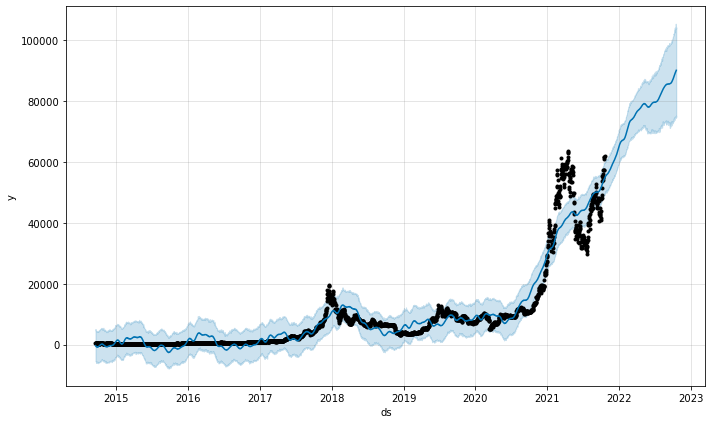

In [11]:
model_tuned = Prophet(changepoint_prior_scale = 0.1)
# fit the model on the entire dataset
model_tuned.fit(bc_date_adjclose)

#Make a dataframe for future predictions and specify the capacity in the future. 
#Predict next 500 days after the final date of October 18, 2021
future = model.make_future_dataframe(periods=365,freq='D')
forecast = model_tuned.predict(future)

#Plotting the predicted values 
plot1 = model.plot(forecast)

# Forecasting Historical Data w/ Tuned Model

In [12]:
from datetime import date, timedelta

In [13]:
#define the period for which we want a prediction
#prediction over last 7 days of the data collected 
future1 = list()
start_date = date(2021, 10, 12)
end_date = date(2021, 10, 18)
delta = timedelta(days=1)
while start_date <= end_date:
    future1.append([start_date])
    start_date += delta
future1 = pd.DataFrame(future1)
future1.columns = ['ds']
future1['ds']= to_datetime(future1['ds'])

In [14]:
# use the model to make a forecast
t_model = Prophet(changepoint_prior_scale = 0.1)
t_model.fit(bc_date_adjclose)
forecast1 = t_model.predict(future1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


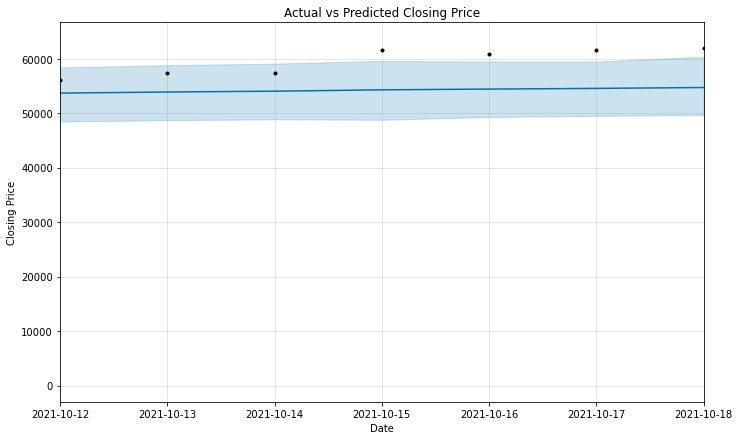

In [15]:
# plot forecast
t_model.plot(forecast1)
plt.xlim([date(2021, 10, 12), date(2021, 10, 18)])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Price')
plt.show()

In [16]:
from sklearn.metrics import mean_absolute_error

In [17]:
# calculate MAE between expected and predicted values
y_true = bc_date_adjclose['y'][-7:].values
y_pred = forecast1['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 5317.954


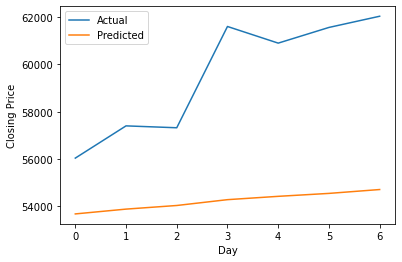

In [18]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [19]:
# summarize the forecast to compare values
bc_date_adjclose['ds'] = pd.to_datetime(bc_date_adjclose['ds'])
new = forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(bc_date_adjclose)
new['Difference'] = new['y'] - new['yhat']
new.rename(columns={'ds':'Date', 'yhat': 'Prediction', 'yhat_lower':'Lower Prediction',
                     'yhat_upper': 'Upper Prediction', "y": 'Actual'})

<ipython-input-19-f07115f582f0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_date_adjclose['ds'] = pd.to_datetime(bc_date_adjclose['ds'])


,Date,Prediction,Lower Prediction,Upper Prediction,Actual,Difference
0,2021-10-12,53686.953259,48469.237356,58416.045494,56041.058594,2354.105335
1,2021-10-13,53889.493368,48713.542446,58821.279742,57401.097656,3511.604288
2,2021-10-14,54042.312687,48882.828269,59099.317638,57321.523438,3279.210751
3,2021-10-15,54288.335965,48790.006059,59616.529452,61593.949219,7305.613254
4,2021-10-16,54428.603040,49299.067649,59485.463806,60892.179688,6463.576648
5,2021-10-17,54552.530267,49509.778560,59494.391901,61553.617188,7001.086921
6,2021-10-18,54715.595365,49664.241831,60372.486686,62026.078125,7310.482760


# Forecasting Future Data w/ Tuned Model

In [20]:
#define the period for which we want a prediction
#prediction over the next 100 days 
future2 = list()
start_date = date(2021, 10, 19)
end_date = date(2021, 10, 25)
delta = timedelta(days=1)
while start_date <= end_date:
    future2.append([start_date])
    start_date += delta
future2 = pd.DataFrame(future2)
future2.columns = ['ds']
future2['ds']= to_datetime(future2['ds'])

In [21]:
# use the model to make a forecast
forecast2 = t_model.predict(future2)
col1 = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
# summarize the forecast
forecast2[col1].rename(columns={'ds':'Date', 'yhat': 'Prediction', 'yhat_lower':'Lower Prediction',
                     'yhat_upper': 'Upper Prediction'}).head(14)

,Date,Prediction,Lower Prediction,Upper Prediction
0,2021-10-19,54795.901388,49381.242407,59848.968583
1,2021-10-20,54947.540716,49411.063095,60076.622057
2,2021-10-21,55047.148205,49654.497234,60140.002271
3,2021-10-22,55238.626254,49965.971744,60743.452332
4,2021-10-23,55324.006641,49856.616311,60377.655198
5,2021-10-24,55393.693907,50269.456427,60668.072048
6,2021-10-25,55504.132085,50395.891659,60697.815349


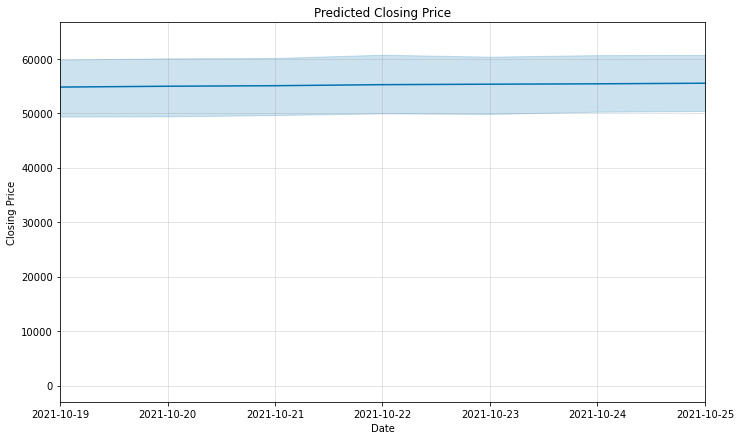

In [22]:
# plot forecast
t_model.plot(forecast2)
plt.xlim([date(2021, 10, 19), date(2021, 10, 25)])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Predicted Closing Price')
plt.show()

Real time series frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately.

Prophet Documentation:
https://facebook.github.io/prophet/docs/trend_changepoints.html#automatic-changepoint-detection-in-prophet

Text(0.5, 1.0, 'Changepoints')

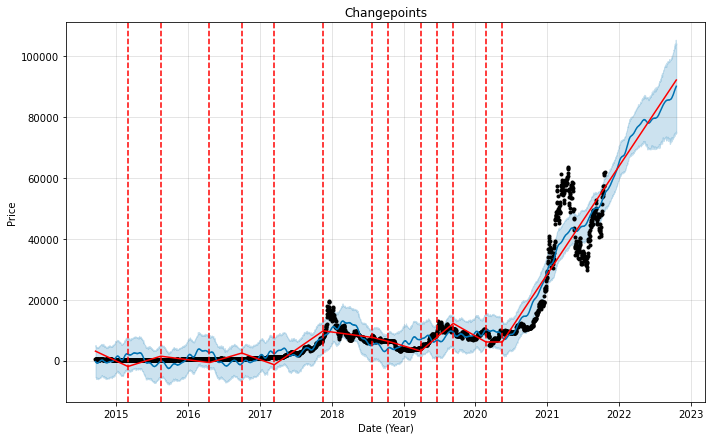

In [23]:
fig = t_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), t_model, forecast)
plt.xlabel('Date (Year)')
plt.ylabel('Price')
plt.title('Changepoints')

In [24]:
print(t_model.changepoints)

83     2014-12-09
165    2015-03-01
248    2015-05-23
331    2015-08-14
413    2015-11-04
496    2016-01-26
579    2016-04-18
661    2016-07-09
744    2016-09-30
827    2016-12-22
909    2017-03-14
992    2017-06-05
1075   2017-08-27
1158   2017-11-18
1240   2018-02-08
1323   2018-05-02
1406   2018-07-24
1488   2018-10-14
1571   2019-01-05
1654   2019-03-29
1736   2019-06-19
1819   2019-09-10
1902   2019-12-02
1984   2020-02-22
2067   2020-05-16
Name: ds, dtype: datetime64[ns]


Dates above can be researched to see what outside sources may have caused the change

# Cross Validation

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point.

This cross validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period).

The output of cross_validation is a dataframe with the true values y and the out-of-sample forecast values yhat, at each simulated forecast date and for each cutoff date. In particular, a forecast is made for every observed point between cutoff and cutoff + horizon.

In [25]:
df_cv = cross_validation(t_model, initial='100 days', period='180 days', horizon = '365 days')
df_cv

INFO:fbprophet:Making 12 forecasts with cutoffs between 2015-05-18 00:00:00 and 2020-10-18 00:00:00


  0%|          | 0/12 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-05-19,236.586448,217.697837,255.756881,231.947006,2015-05-18
1,2015-05-20,235.610671,217.625144,255.277591,234.018005,2015-05-18
2,2015-05-21,236.024430,216.915034,254.733246,235.343994,2015-05-18
3,2015-05-22,236.731190,217.206973,256.899084,240.348007,2015-05-18
4,2015-05-23,237.383231,219.284237,255.147181,238.871994,2015-05-18
...,...,...,...,...,...,...
4367,2021-10-14,10227.977387,408.813183,19972.337388,57321.523438,2020-10-18
4368,2021-10-15,10246.158204,95.187424,20235.974193,61593.949219,2020-10-18
4369,2021-10-16,10268.696762,378.793380,20099.812813,60892.179688,2020-10-18
4370,2021-10-17,10264.498770,254.613719,20262.902820,61553.617188,2020-10-18


The performance_metrics utility can be used to compute some useful statistics of the prediction performance (yhat, yhat_lower, and yhat_upper compared to y), as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), median absolute percent error (MDAPE) and coverage of the yhat_lower and yhat_upper estimates.

In [26]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,6.124732e+06,2474.819631,1384.003964,0.218943,0.174601,0.401602
1,38 days,6.601699e+06,2569.377071,1434.094749,0.223954,0.174601,0.399314
2,39 days,7.038967e+06,2653.105158,1482.428897,0.229440,0.179448,0.396072
3,40 days,7.421052e+06,2724.160745,1527.514227,0.234848,0.188107,0.392449
4,41 days,7.832530e+06,2798.665702,1573.909455,0.240236,0.191769,0.387872


Cross validation performance metrics can be visualized with plot_cross_validation_metric, here shown for MAPE. Dots show the absolute percent error for each prediction in df_cv. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots.

The MAPE (Mean Absolute Percent Error) measures the size of the error in percentage terms (easy interpretation). It is calculated as the average of the unsigned percentage error.

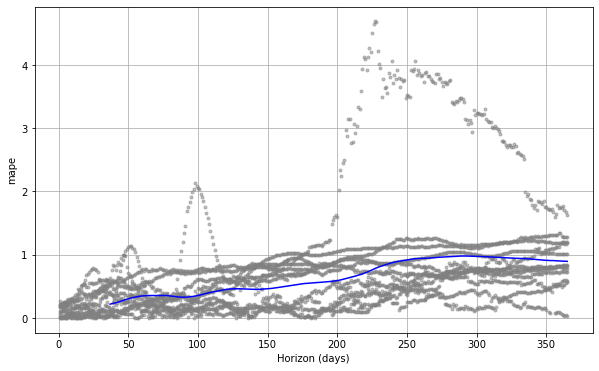

In [27]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

We see for this forecast that errors around 20% are typical for predictions one month into the future, and that errors increase up to around 100% for predictions that are a 9 months out and decrease to 90% as it gets closer to 1 year.

The size of the rolling window can be changed with the optional argument rolling_window, which specifies the proportion of forecasts to use in each rolling window. The default is 0.1, corresponding to 10% of rows from df_cv included in each window; increasing this will lead to a smoother average curve in the figure. 

# Adding Regressors

In [28]:
bc_prophet = bc[['Date','Adj Close']]
bc_prophet.columns = ['ds', 'y']

In [29]:
bc_prophet['Open'] = bc['Open']
bc_prophet['High'] = bc['High']
bc_prophet['Low'] = bc['Low']
bc_prophet['Volume'] = bc['Volume']
bc_prophet['Return'] = bc['Return']
bc_prophet=bc_prophet.dropna()
train_X= bc_prophet[:2577]
test_X= bc_prophet[2577:]

<ipython-input-29-935f4657fde4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_prophet['Open'] = bc['Open']
<ipython-input-29-935f4657fde4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_prophet['High'] = bc['High']
<ipython-input-29-935f4657fde4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [30]:
pro_regressor= Prophet(changepoint_prior_scale = 0.1)
pro_regressor.add_regressor('Open')
pro_regressor.add_regressor('High')
pro_regressor.add_regressor('Low')
pro_regressor.add_regressor('Volume')
pro_regressor.add_regressor('Return')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


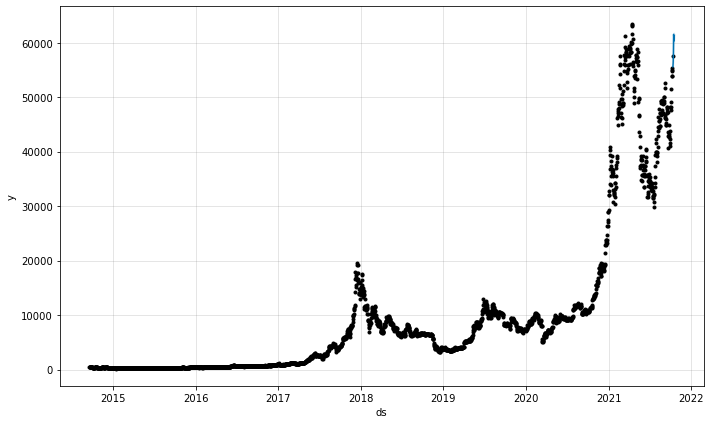

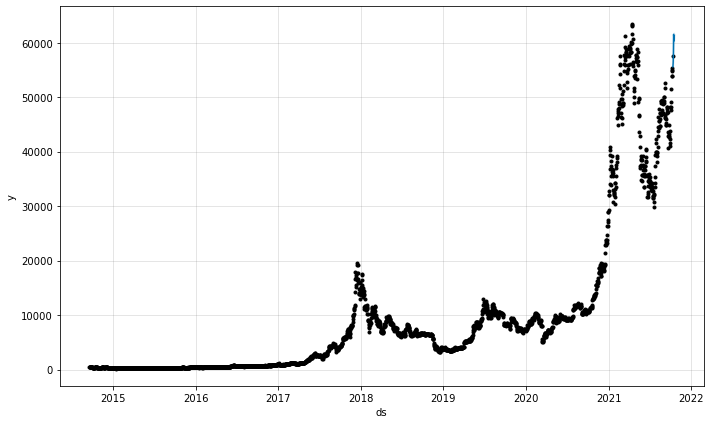

In [31]:
pro_regressor.fit(train_X)
forecast_data = pro_regressor.predict(test_X)
pro_regressor.plot(forecast_data)

In [32]:
y_true = bc_prophet['y'][-7:].values
y_pred = forecast_data['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 602.684


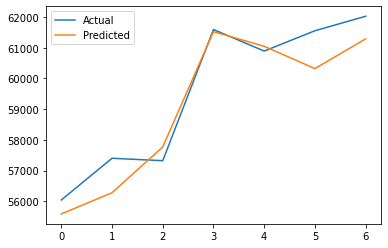

In [33]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [34]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2021-10-12,55588.209993,55241.560108,55919.452306
1,2021-10-13,56277.079350,55928.520533,56615.783695
2,2021-10-14,57770.079757,57439.601502,58122.726764
3,2021-10-15,61525.144806,61177.554425,61880.598340
4,2021-10-16,61048.276524,60693.011098,61393.869292
5,2021-10-17,60320.751023,59974.489250,60666.747828
6,2021-10-18,61290.479082,60943.487132,61612.372164


In [35]:
bc_prophet['ds'] = pd.to_datetime(bc_prophet['ds'])
new1 = forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(bc_prophet)
new1['Difference'] = new1['y'] - new1['yhat']
new1 = new1.drop(columns = ['Open', "High", 'Low', 'Volume', 'Return'])
new1.rename(columns={'ds':'Date', 'yhat': 'Prediction', 'yhat_lower':'Lower Prediction',
                     'yhat_upper': 'Upper Prediction', 'y': 'Actual'})

,Date,Prediction,Lower Prediction,Upper Prediction,Actual,Difference
0,2021-10-12,55588.209993,55241.560108,55919.452306,56041.058594,452.848601
1,2021-10-13,56277.079350,55928.520533,56615.783695,57401.097656,1124.018306
2,2021-10-14,57770.079757,57439.601502,58122.726764,57321.523438,-448.556319
3,2021-10-15,61525.144806,61177.554425,61880.598340,61593.949219,68.804413
4,2021-10-16,61048.276524,60693.011098,61393.869292,60892.179688,-156.096836
5,2021-10-17,60320.751023,59974.489250,60666.747828,61553.617188,1232.866165
6,2021-10-18,61290.479082,60943.487132,61612.372164,62026.078125,735.599043


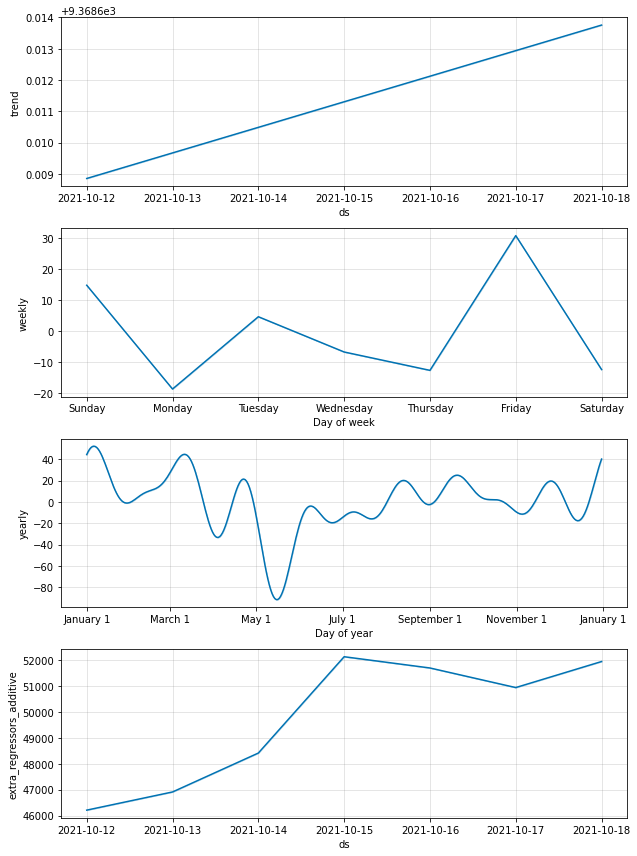

In [36]:
fig = pro_regressor.plot_components(forecast_data)

In [37]:
df_cv = cross_validation(pro_regressor, initial='100 days', period='180 days', horizon = '365 days')
pm = performance_metrics(df_cv, rolling_window=0.1)
display(pm.head(),pm.tail())

INFO:fbprophet:Making 12 forecasts with cutoffs between 2015-05-11 00:00:00 and 2020-10-11 00:00:00


  0%|          | 0/12 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,15714.514748,125.357548,66.733256,0.096284,0.006608,0.604879
1,38 days,16396.989175,128.050729,68.624930,0.100951,0.006805,0.600083
2,39 days,17039.154817,130.534114,70.540112,0.105526,0.006818,0.591535
3,40 days,18388.683266,135.604879,73.806027,0.109959,0.006968,0.581804
4,41 days,21323.856995,146.026905,77.926085,0.114233,0.006989,0.573394


,horizon,mse,rmse,mae,mape,mdape,coverage
324,361 days,130588.796335,361.370719,197.941288,0.069168,0.013031,0.418578
325,362 days,132235.527189,363.642032,198.632740,0.069268,0.013230,0.412653
326,363 days,131127.520958,362.115342,197.565859,0.069081,0.013230,0.415138
327,364 days,131151.900459,362.149003,198.438726,0.068766,0.013638,0.412844
328,365 days,129374.647022,359.686874,198.159730,0.068753,0.013504,0.407492


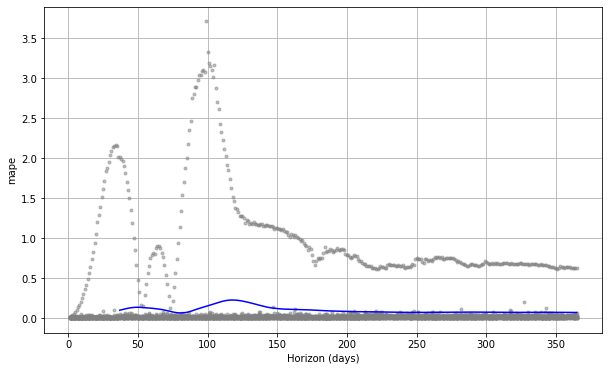

In [38]:
fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.1)
plt.show()